In [1]:
import pandas as pd
import numpy as np
import yaml
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

In [2]:
site_path = '../../sites/TFBS/scripts/10000_unfiltered_sites_CIS_BP_v2.yaml'
diff_path = '../../cancer_specific_TFs/UCSC_online_DGE_results/DEG_results_GTEX_Blood vs. TCGA_Breast_Invasive_Carcinoma.csv'

GC_corrected_cfDNA_path = '../GC_correction/files/exclusion_filtered.GC_corrected.tsv'
uncorrected_cfDNA_path = '../GC_correction/files/exclusion_filtered.uncorrected.tsv'

overlaps_path = '../../sites/TFBS/overlaps_10000_sites/'

In [3]:
#import list of TFs
with open(site_path, 'r') as f:
    TFs = yaml.safe_load(f)

TFs = list(TFs['site_lists'].keys())
TFs = [m.rsplit('.',2)[0] for m in TFs]
print(len(TFs))

377


In [4]:
##import cfDNA correlations
GC_corrected_cfDNA_data = pd.read_csv(GC_corrected_cfDNA_path, sep='\t')
GC_corrected_cfDNA_data['gene_name'] = GC_corrected_cfDNA_data['site_name'].str.rsplit('.hg38',1, expand=True)[0]
GC_corrected_cfDNA_data = GC_corrected_cfDNA_data.drop(columns = ['site_name'])

#import cfDNA correlations
uncorrected_cfDNA_data = pd.read_csv(uncorrected_cfDNA_path, sep='\t')
uncorrected_cfDNA_data['gene_name'] = uncorrected_cfDNA_data['site_name'].str.rsplit('.hg38',1, expand=True)[0]
uncorrected_cfDNA_data = uncorrected_cfDNA_data.drop(columns = ['site_name'])

#reformat for boxplot 
GC_corrected_cfDNA_data = GC_corrected_cfDNA_data.set_index('gene_name')
GC_corrected_cfDNA_data.columns = GC_corrected_cfDNA_data.columns.str.split('_',1,expand = True)
GC_corrected_cfDNA_data = GC_corrected_cfDNA_data.stack()
GC_corrected_cfDNA_data = GC_corrected_cfDNA_data.reset_index(1).rename(columns = {'level_1':'feature_type'})

#reformat for boxplot 
uncorrected_cfDNA_data = uncorrected_cfDNA_data.set_index('gene_name')
uncorrected_cfDNA_data.columns = uncorrected_cfDNA_data.columns.str.split('_',1,expand = True)
uncorrected_cfDNA_data = uncorrected_cfDNA_data.stack()
uncorrected_cfDNA_data = uncorrected_cfDNA_data.reset_index(1).rename(columns = {'level_1':'feature_type'})

#merge into single dataframe
GC_corrected_cfDNA_data['correction']='GC_corrected'
uncorrected_cfDNA_data['correction']='uncorrected'

cfDNA_data = GC_corrected_cfDNA_data.append(uncorrected_cfDNA_data)

In [5]:
cfDNA_data.head()

,feature_type,lin-reg-RMSE,pearson-adjusted-p-val,pearson-pval,pearson-r,correction
gene_name,,,,,,
AHR,amplitude,0.529746,2.722179e-01,9.025794e-02,0.122918,GC_corrected
AHR,central_coverage,0.046264,3.897537e-08,2.584573e-09,-0.414170,GC_corrected
AHR,mean_coverage,0.017259,5.042103e-08,4.012284e-09,-0.409591,GC_corrected
AR,amplitude,0.580089,8.535810e-01,6.964664e-01,-0.028407,GC_corrected
AR,central_coverage,0.048872,1.269795e-02,4.205059e-03,-0.206235,GC_corrected


In [6]:
export_df = pd.DataFrame(index=TFs)

In [7]:
#import differential expression
results = pd.read_csv(diff_path, sep=',').rename(columns = {'Unnamed: 0':'gene_name'})

#keep only tfs
key_results = results[results['gene_name'].isin(TFs)].sort_values(by = 'adj.P.Val')
print('matched TFs', len(key_results))

#get blood and cancer differential TFs
all_blood_TFs = key_results[(key_results['adj.P.Val']<=0.05) & (key_results['logFC']>1.5)]
all_cancer_TFs = key_results[(key_results['adj.P.Val']<=0.05) & (key_results['logFC']<-1.5)]

print('blood',len(all_blood_TFs))
print('cancer',len(all_cancer_TFs))

matched TFs 346
blood 82
cancer 107


In [8]:
#get info for sup table
export_df[['logFC','adj.P.Val']] = key_results.set_index('gene_name')[['logFC','adj.P.Val']]
export_df.columns = export_df.columns+'_RNA_expr'
export_df['group'] = np.where(export_df.index.isin(all_blood_TFs['gene_name']),'Blood','Non_differential')
export_df['group'] = np.where(export_df.index.isin(all_cancer_TFs['gene_name']),'BRCA',export_df['group'])
export_df['group'].value_counts()

Non_differential    188
BRCA                107
Blood                82
Name: group, dtype: int64

In [9]:
#find blood TFs that overlap with an average of <400 sites
blood_keep = []
mean_overlaps_for_export = {}
print('initial blood factors',len(all_blood_TFs))
for tf in all_blood_TFs['gene_name']:
    current_path = overlaps_path+'/'+tf+'.hg38.10000_top10000_vs_all.txt'
    current = pd.read_csv(current_path, sep = '\t')
    current['name_b'] = current['TF_b'].str.split('.', 1, expand = True)[0]
    
    #get overlaps with the other class
    current = current[current['name_b'].isin(all_cancer_TFs['gene_name'])]
    current = current.sort_values('window', ascending = False)
    max_val = current.iloc[0]['window']
    mean_val = current['window'].mean()
#     print(tf,current.iloc[0]['name_b'], current.iloc[0]['window'])
#     print(tf,np.round(mean_val))
    
    if mean_val<400:
        blood_keep.append(tf)
    mean_overlaps_for_export[tf] = np.round(mean_val,1)
print('non-overlaping blood factors',len(blood_keep))

initial blood factors 82
non-overlaping blood factors 22


In [10]:
#find cancer TFs that overlap with an average of <400 sites
cancer_keep = []
print('initial cancer factors',len(all_cancer_TFs))

for tf in all_cancer_TFs['gene_name']:
    current_path = overlaps_path+'/'+tf+'.hg38.10000_top10000_vs_all.txt'
    current = pd.read_csv(current_path, sep = '\t')
    current['name_b'] = current['TF_b'].str.split('.', 1, expand = True)[0]
    
    #get overlaps with the other class
    current = current[current['name_b'].isin(all_blood_TFs['gene_name'])]
    current = current.sort_values('window', ascending = False)
    max_val = current.iloc[0]['window']
    mean_val = current['window'].mean()
#     print(tf,current.iloc[0]['name_b'], current.iloc[0]['window'])
#     print(tf,np.round(mean_val))
    
    if mean_val<400:
        cancer_keep.append(tf)
    mean_overlaps_for_export[tf] = np.round(mean_val,1)
print('non-overlaping cancer factors',len(cancer_keep))

initial cancer factors 107
non-overlaping cancer factors 35


In [11]:
export_df['mean_overlaps_with_other_type'] = pd.Series(mean_overlaps_for_export)
export_df = export_df.reset_index().rename(columns={'index':'TF'})
export_df.to_csv('files/S4_differential_RNA_TFs.tsv',sep='\t', index = False)

In [12]:
export_df

,TF,logFC_RNA_expr,adj.P.Val_RNA_expr,group,mean_overlaps_with_other_type
0,AHR,-1.058544,3.867705e-56,Non_differential,NaN
1,AR,-7.829840,0.000000e+00,BRCA,184.2
2,ARID3A,3.801951,0.000000e+00,Blood,560.1
3,ARNT,0.468912,2.746122e-50,Non_differential,NaN
4,ARNTL,2.502083,0.000000e+00,Blood,585.8
...,...,...,...,...,...
372,ZNF792,-0.373592,7.812929e-19,Non_differential,NaN
373,ZSCAN16,-0.122248,5.398944e-03,Non_differential,NaN
374,ZSCAN22,-0.314206,3.093566e-20,Non_differential,NaN
375,ZSCAN4,NaN,NaN,Non_differential,NaN


In [13]:
# #get non differential/non_overlapping
# non_diff = key_results[~(key_results['gene_name'].isin(cancer_keep)) & ~(key_results['gene_name'].isin(blood_keep))]['gene_name']
# print('blood',len(blood_keep))
# print('cancer',len(cancer_keep))
# print('non_diff',len(non_diff))

In [14]:
blood_TFs_cfDNA = cfDNA_data[cfDNA_data.index.isin(blood_keep)].copy()
blood_TFs_cfDNA['group'] = 'Blood'

cancer_TFs_cfDNA = cfDNA_data[cfDNA_data.index.isin(cancer_keep)].copy()
cancer_TFs_cfDNA['group'] = 'BRCA'

boxplot_data = cancer_TFs_cfDNA.append(blood_TFs_cfDNA)

# non_diff_TFs_cfDNA = cfDNA_data[cfDNA_data.index.isin(non_diff)].copy()
# non_diff_TFs_cfDNA['group'] = 'non-diff'
# boxplot_data = boxplot_data.append(non_diff_TFs_cfDNA)


boxplot_data['significant'] = boxplot_data['pearson-adjusted-p-val']<0.05
boxplot_data['direction'] = np.where(boxplot_data['pearson-r']>0,'positive','negative')

print(len(blood_TFs_cfDNA)/3/2)# 3 features 2 corrections
print(len(cancer_TFs_cfDNA)/3/2)
print(len(boxplot_data)/3/2)

22.0
35.0
57.0


In [15]:
color_dict = {'central_coverage':['lightblue','peachpuff'],
              'mean_coverage':['lightblue','peachpuff'],
              'amplitude':['peachpuff','lightblue']}

central_coverage


0
correction   group significant direction    
GC_corrected BRCA  False       negative   12
                               positive   12
                   True        negative    9
                               positive    2
             Blood False       negative    1
                               positive    6
                   True        positive   15
uncorrected  BRCA  False       negative   10
                               positive   10
                   True        negative   15
             Blood False       negative    4
                               positive    6
                   True        negative    2
                               positive   10

central_coverage significant proportion


0
correction   group significant    
GC_corrected BRCA  False        24
                   True         11
             Blood False         7
                   True         15
uncorrected  BRCA  False        20
                   True         15
             Blood False        10
                   True         12

mean_coverage


0
correction   group significant direction    
GC_corrected BRCA  False       negative   10
                               positive   13
                   True        negative   10
                               positive    2
             Blood False       negative    4
                               positive    4
                   True        positive   14
uncorrected  BRCA  False       negative   10
                               positive    7
                   True        negative   17
                               positive    1
             Blood False       negative    5
                               positive    4
                   True        negative    2
                               positive   11

mean_coverage significant proportion


0
correction   group significant    
GC_corrected BRCA  False        23
                   True         12
             Blood False         8
                   True         14
uncorrected  BRCA  False        17
                   True         18
             Blood False         9
                   True         13

amplitude


0
correction   group significant direction    
GC_corrected BRCA  False       negative   15
                               positive   15
                   True        positive    5
             Blood False       negative   10
                               positive    5
                   True        negative    7
uncorrected  BRCA  False       negative   13
                               positive   17
                   True        positive    5
             Blood False       negative    8
                               positive    7
                   True        negative    7

amplitude significant proportion


0
correction   group significant    
GC_corrected BRCA  False        30
                   True          5
             Blood False        15
                   True          7
uncorrected  BRCA  False        30
                   True          5
             Blood False        15
                   True          7

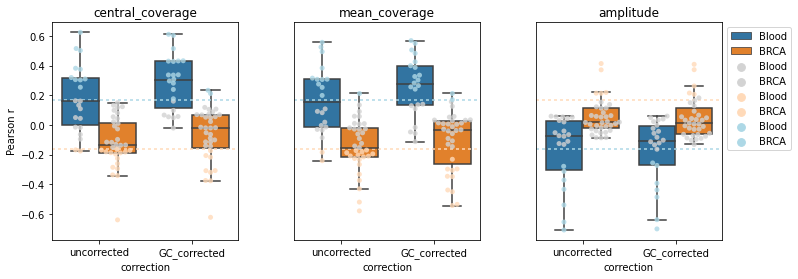

In [16]:
markersize = 5
significant_cutoff = np.abs(boxplot_data[(boxplot_data['significant']==True)]['pearson-r']).min()

fig,axes = plt.subplots(1,3,figsize = (12,4), sharey=True)
for i,feature_type in enumerate(['central_coverage','mean_coverage','amplitude']):
        
    #get data for that feature
    df = boxplot_data[(boxplot_data['feature_type']==feature_type)]

    #separate out data for the swarmplot
    significant_pos = df[(df['significant']) & (df['pearson-r']>0)]
    significant_neg = df[(df['significant']) & (df['pearson-r']<0)]
    non_sig = df[~(df['significant'])]

    print(feature_type)
    display(pd.DataFrame(df[['correction','group','significant','direction']].value_counts(sort = False)))

    print(feature_type,'significant proportion')
    display(pd.DataFrame(df[['correction','group','significant']].value_counts(sort = False)))

    pos_color = color_dict[feature_type][0]
    neg_color = color_dict[feature_type][1]
    
    #generate boxplot
    sns.boxplot(x = df['correction'],
                y = df['pearson-r'],
                hue = df['group'],
                hue_order = ['Blood','BRCA'],
                order = ['uncorrected','GC_corrected'],
                palette = ['tab:blue','tab:orange','tab:grey'],
                ax = axes[i],
                showfliers = False)

    #plot non significant swarmplot points
    sns.swarmplot(x = non_sig['correction'],
                  y = non_sig['pearson-r'],
                  order = ['uncorrected','GC_corrected'],
                  hue = non_sig['group'],
                  hue_order = ['Blood','BRCA'],
                  s= markersize,
                  dodge = True,
                  palette = ['lightgrey','lightgrey','lightgrey'],
                  alpha = 0.8,
                  ax = axes[i])


    #plot significant positive swarmplot points
    sns.swarmplot(x = significant_pos['correction'],
                  y = significant_pos['pearson-r'],
                  order = ['uncorrected','GC_corrected'],
                  hue = significant_pos['group'],
                  hue_order = ['Blood','BRCA'],
                  s= markersize,
                  dodge = True,
                  palette = [pos_color,pos_color,pos_color],
                  alpha = 0.8,
                  ax = axes[i])

    #plot significant negative swarmplot points
    sns.swarmplot(x = significant_neg['correction'],
                  y = significant_neg['pearson-r'],
                  order = ['uncorrected','GC_corrected'],
                  hue = significant_neg['group'],
                  hue_order = ['Blood','BRCA'],
                  s= markersize,
                  dodge = True,
                  palette = [neg_color,neg_color,neg_color],
                  alpha = 0.8,
                  ax = axes[i])

    #add significance cutoffs
    axes[i].axhline(significant_cutoff, color = pos_color, alpha = 1, dashes = [2,2])
    axes[i].axhline(-significant_cutoff, color = neg_color, alpha = 1, dashes = [2,2])

    axes[i].set_title(feature_type)
    axes[i].get_legend().remove()
    axes[i].tick_params(labelleft=False, left = False)
    axes[i].set_ylabel('')

axes[0].tick_params(labelleft=True, left = True)
axes[0].set_ylabel('Pearson r')

axes[i].legend(bbox_to_anchor = [1,1], loc= 'upper left')          
fig.subplots_adjust(right = 0.9, wspace = .3)
fig.savefig('plots/blood_and_cancer.pdf')
plt.show()


In [17]:
#median values from the plots above (not in the same order)
pd.DataFrame(boxplot_data.groupby(['feature_type','correction','group'])['pearson-r'].median())[::-1]

pearson-r
feature_type     correction   group           
mean_coverage    uncorrected  Blood   0.153228
                              BRCA   -0.152953
                 GC_corrected Blood   0.273566
                              BRCA   -0.033086
central_coverage uncorrected  Blood   0.161552
                              BRCA   -0.137084
                 GC_corrected Blood   0.301686
                              BRCA   -0.020622
amplitude        uncorrected  Blood  -0.074546
                              BRCA    0.018709
                 GC_corrected Blood  -0.108122
                              BRCA    0.012870

In [18]:
# cfDNA_data[(cfDNA_data['feature_type']=='amplitude') & (cfDNA_data['correction']=='GC_corrected') & (cfDNA_data['pearson-pval']<0.05)].sort_values(by='pearson-pval').tail(30).head(10)
# cfDNA_data[(cfDNA_data['feature_type']=='central_coverage') & (cfDNA_data['correction']=='GC_corrected') & (cfDNA_data['pearson-pval']<0.05)].sort_values(by='pearson-pval').tail(30).head(10)
#

In [19]:
from scipy.stats import wilcoxon
for i,feature_type in enumerate(['central_coverage','mean_coverage','amplitude']):
    for group in ['Blood','BRCA']:
        a = boxplot_data[(boxplot_data['group']==group) & (boxplot_data['feature_type']==feature_type) & (boxplot_data['correction']=='GC_corrected')]
        b = boxplot_data[(boxplot_data['group']==group) & (boxplot_data['feature_type']==feature_type) & (boxplot_data['correction']=='uncorrected')]
        print(feature_type,group)
        stat,pval = wilcoxon(a['pearson-r'],b['pearson-r'])
        #print('stat:',stat,'pval:','{:.2E}'.format(pval))
        print('stat:',stat,'pval:',np.round(pval,5))
        print('\n')

central_coverage Blood
stat: 32.0 pval: 0.00126


central_coverage BRCA
stat: 199.0 pval: 0.05744


mean_coverage Blood
stat: 35.0 pval: 0.00192


mean_coverage BRCA
stat: 228.0 pval: 0.15416


amplitude Blood
stat: 101.0 pval: 0.42449


amplitude BRCA
stat: 203.0 pval: 0.06659




In [20]:
from scipy.stats import mannwhitneyu
for i,feature_type in enumerate(['central_coverage','mean_coverage','amplitude']):
    for correction in ['uncorrected','GC_corrected']:
        a = boxplot_data[(boxplot_data['group']=='Blood') & (boxplot_data['feature_type']==feature_type) & (boxplot_data['correction']==correction)]
        b = boxplot_data[(boxplot_data['group']=='BRCA') & (boxplot_data['feature_type']==feature_type) & (boxplot_data['correction']==correction)]
        print(feature_type,correction,len(a),len(b))
        stat,pval = mannwhitneyu(a['pearson-r'],b['pearson-r'])
        print('stat:',stat,'pval:','{:.2E}'.format(pval))
        print('\n')

central_coverage uncorrected 22 35
stat: 661.0 pval: 6.30E-06


central_coverage GC_corrected 22 35
stat: 700.0 pval: 2.53E-07


mean_coverage uncorrected 22 35
stat: 653.0 pval: 1.16E-05


mean_coverage GC_corrected 22 35
stat: 678.0 pval: 1.63E-06


amplitude uncorrected 22 35
stat: 159.0 pval: 2.19E-04


amplitude GC_corrected 22 35
stat: 162.0 pval: 2.65E-04




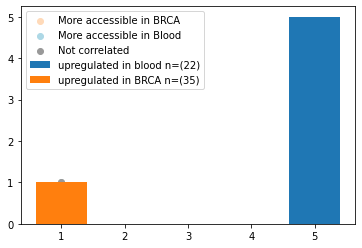

In [21]:
#generate legend
plt.bar(5,5,color = 'tab:blue', label = 'upregulated in blood n=('+str(len(blood_keep))+')')
plt.bar(1,1,color = 'tab:orange', label = 'upregulated in BRCA n=('+str(len(cancer_keep))+')')


plt.scatter(1,1, color = 'peachpuff', label = 'More accessible in BRCA')
plt.scatter(1,1, color = 'lightblue', label = 'More accessible in Blood')
plt.scatter(1,1, color = '0.6', label = 'Not correlated')

plt.legend();
plt.savefig('plots/blood_and_cancer_legend.pdf')